# Import Librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import math
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)


pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.precision', 3)
pd.set_option('display.width', 3000)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 38)

# Util Functions

In [3]:
def get_label(row_number):
    # Calculate the label based on the row number
    
    row_number = row_number + 1
    label = math.ceil(row_number / 380)
    return label


def change_date(str):
    try:
        date = pd.to_datetime(str, format="%d/%m/%Y")
    except:
        date = pd.to_datetime(str, format="%d/%m/%y", errors='coerce')

    return date

def wdl(row):
    if row['Goals'] > row['Opp Goals']:
        return 'W'
    elif row['Goals'] == row['Opp Goals']:
        return 'D'
    else: 
        return 'L'

# Plotting Function

def make_scatter(df, x,y,animation_frame,hover_name,color,animation_group=None,size=None,title=None):

    range_x = [df[x].min(), df[x].max()]
    range_y = [df[y].min(), df[y].max()]

    fig = px.scatter(df,title=title, x=x, y=y, animation_frame=animation_frame, animation_group=animation_group, size=size, hover_name=hover_name, color=color,
                                    range_x=range_x, range_y= range_y, width=1000, height=600)
    
    if not size:                               
        fig.update_traces(marker_line_width=1, marker_size=8)
    fig.show()



# Load Data

In [4]:
folder='Clean Data\Whole_Clean_data.csv'
stats_df = pd.read_csv(folder, index_col=[0])

stats_df['HTGD'] = stats_df['HTGS'] - stats_df['HTGC']
stats_df['ATGD'] = stats_df['ATGS'] - stats_df['ATGC']
stats_df['FPD'] = stats_df['HTFormPts'] - stats_df['ATFormPts']


cols = ['HTGS', 'HTGC', 'ATGS', 'ATGC','HTGD', 'HTS','HTTS','HTF', 'HTC', 'HTY', 'HTR', 'ATGD','ATS','ATTS', 'ATF', 'ATC', 'ATY', 'ATR', 'HTP', 'ATP']
stats_df.MW = stats_df.MW.astype(float)
stats_df[cols] = stats_df[cols].divide(stats_df.MW, axis=0)
stats_df['HW'] = stats_df.FTR.apply(lambda string: 1 if string == 'H' else 0)

stats_df['Season'] = stats_df.apply(lambda row: get_label(row.name), axis=1) + 2000
stats_df['Date'] = stats_df['Date'].apply(change_date)
stats_df['Home Result'] = stats_df['HW'].apply(lambda x: 'Home Win' if x==1 else 'Draw or Away Win')

# Data Analysis

## Categorical Variables
- Only the output vairable is Categorical

Text(0.5, 1.0, 'Home Wins')

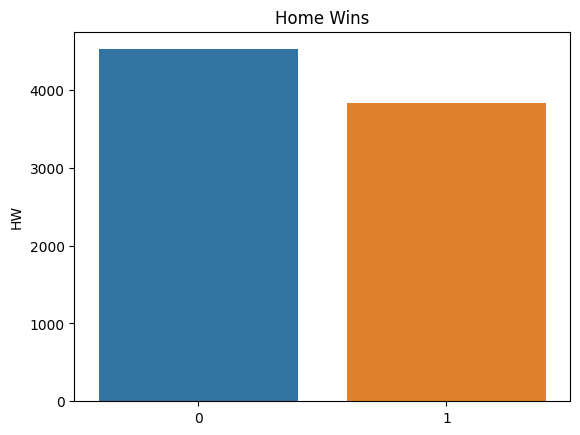

In [5]:
value_counts = stats_df['HW'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts).set_title('Home Wins')

### Stats by Season

In [9]:
stats_df.groupby(['Season','FTR']).count().reset_index().iloc[:,:3]


,Season,FTR,Date
0,2001,A,95
1,2001,D,101
2,2001,H,184
3,2002,A,114
4,2002,D,101
...,...,...,...
61,2021,D,83
62,2021,H,144
63,2022,A,129
64,2022,D,88


In [10]:
wdl_df = stats_df.groupby(['Season','FTR']).count().reset_index().iloc[:,:3]
wdl_df = wdl_df.rename(columns={'Date':'Outcome'})
wdl_df = wdl_df.pivot_table('Outcome',['Season'], 'FTR')
wdl_df = wdl_df[['H','D','A']].reset_index()


fig = go.Figure()
fig.add_trace(go.Bar(x=wdl_df['Season'], y=wdl_df['H'], name='Home Wins'))
fig.add_trace(go.Bar(x=wdl_df['Season'], y=wdl_df['D'], name='Draws'))
fig.add_trace(go.Bar(x=wdl_df['Season'], y=wdl_df['A'], name='Away Wins'))
fig.update_layout(title='Wins Draws by Season' ,xaxis_title='Season', yaxis_title='Occurences',
                           width=1200, height=600)

fig.show()

In [347]:
goals_by_season = stats_df.groupby(['Season']).sum()[['FTHG','FTAG']].reset_index()
# Create a figure with two subplots
fig = go.Figure()


# Add the first set of bars to the first subplot
fig.add_trace(go.Bar(x=goals_by_season['Season'], y=goals_by_season['FTHG'], name='Home Goals'))
# Add the second set of bars to the second subplot
fig.add_trace(go.Bar(x=goals_by_season['Season'], y=goals_by_season['FTAG'], name='Away Goals'))
fig.update_layout(title='Home and Away Goals by Season',xaxis_title='Season', yaxis_title='Goals',
                           width=1200, height=600)

# Show the figure
fig.show()

In [321]:
home_goals = stats_df.groupby(['HomeTeam']).sum()[['FTHG','FTAG']].reset_index()
away_goals = stats_df.groupby(['AwayTeam']).sum()[['FTHG','FTAG']].reset_index()
team_goals_scored = home_goals[['HomeTeam','FTHG']].join(away_goals[['AwayTeam','FTAG']])
team_goals_scored['Total Goals'] = team_goals_scored['FTHG'] + team_goals_scored['FTAG']
team_goals_scored = team_goals_scored.drop(columns=['AwayTeam']).sort_values('FTHG', ascending=False)

fig = go.Figure()

fig.add_trace(go.Bar(x=team_goals_scored['HomeTeam'], y=team_goals_scored['FTHG'], name='Home Goals'))
fig.add_trace(go.Bar(x=team_goals_scored['HomeTeam'], y=team_goals_scored['FTAG'], name='Away Goals'))
fig.update_layout(title='Home and Away Goals by Team since 2000-01',xaxis_title='Teams', yaxis_title='Goals',
                           width=1200, height=600)

fig.show()

## Numerical Variables

### Heat Map

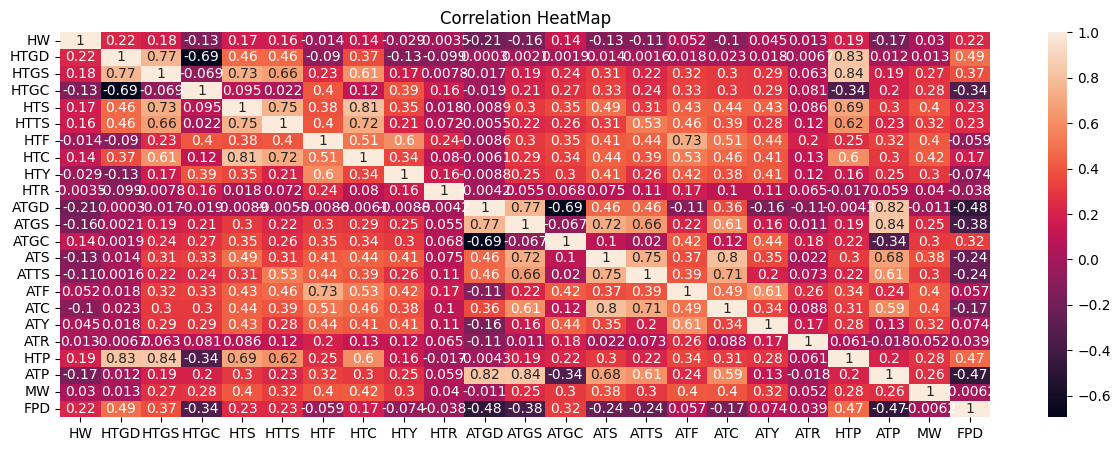

In [397]:
cols =  ['HW','HTGD','HTGS','HTGC','HTS','HTTS', 'HTF', 'HTC', 'HTY', 'HTR', 'ATGD','ATGS','ATGC','ATS','ATTS', 'ATF', 'ATC', 'ATY', 'ATR', 'HTP', 'ATP', 'MW', 'FPD']
corr = stats_df[cols].corr()


plt.figure(figsize=(15,5)) 
plt.title('Correlation HeatMap')
sns.heatmap(corr, annot= True)
plt.show()

Top 5 Features in Term of Correlation

In [398]:
abs(corr['HW']).sort_values(ascending=False)[:11]

HW      1.000
FPD     0.222
HTGD    0.219
ATGD    0.209
HTP     0.194
HTGS    0.183
ATP     0.169
HTS     0.167
ATGS    0.165
HTTS    0.163
HTC     0.144
Name: HW, dtype: float64

### Distributions 

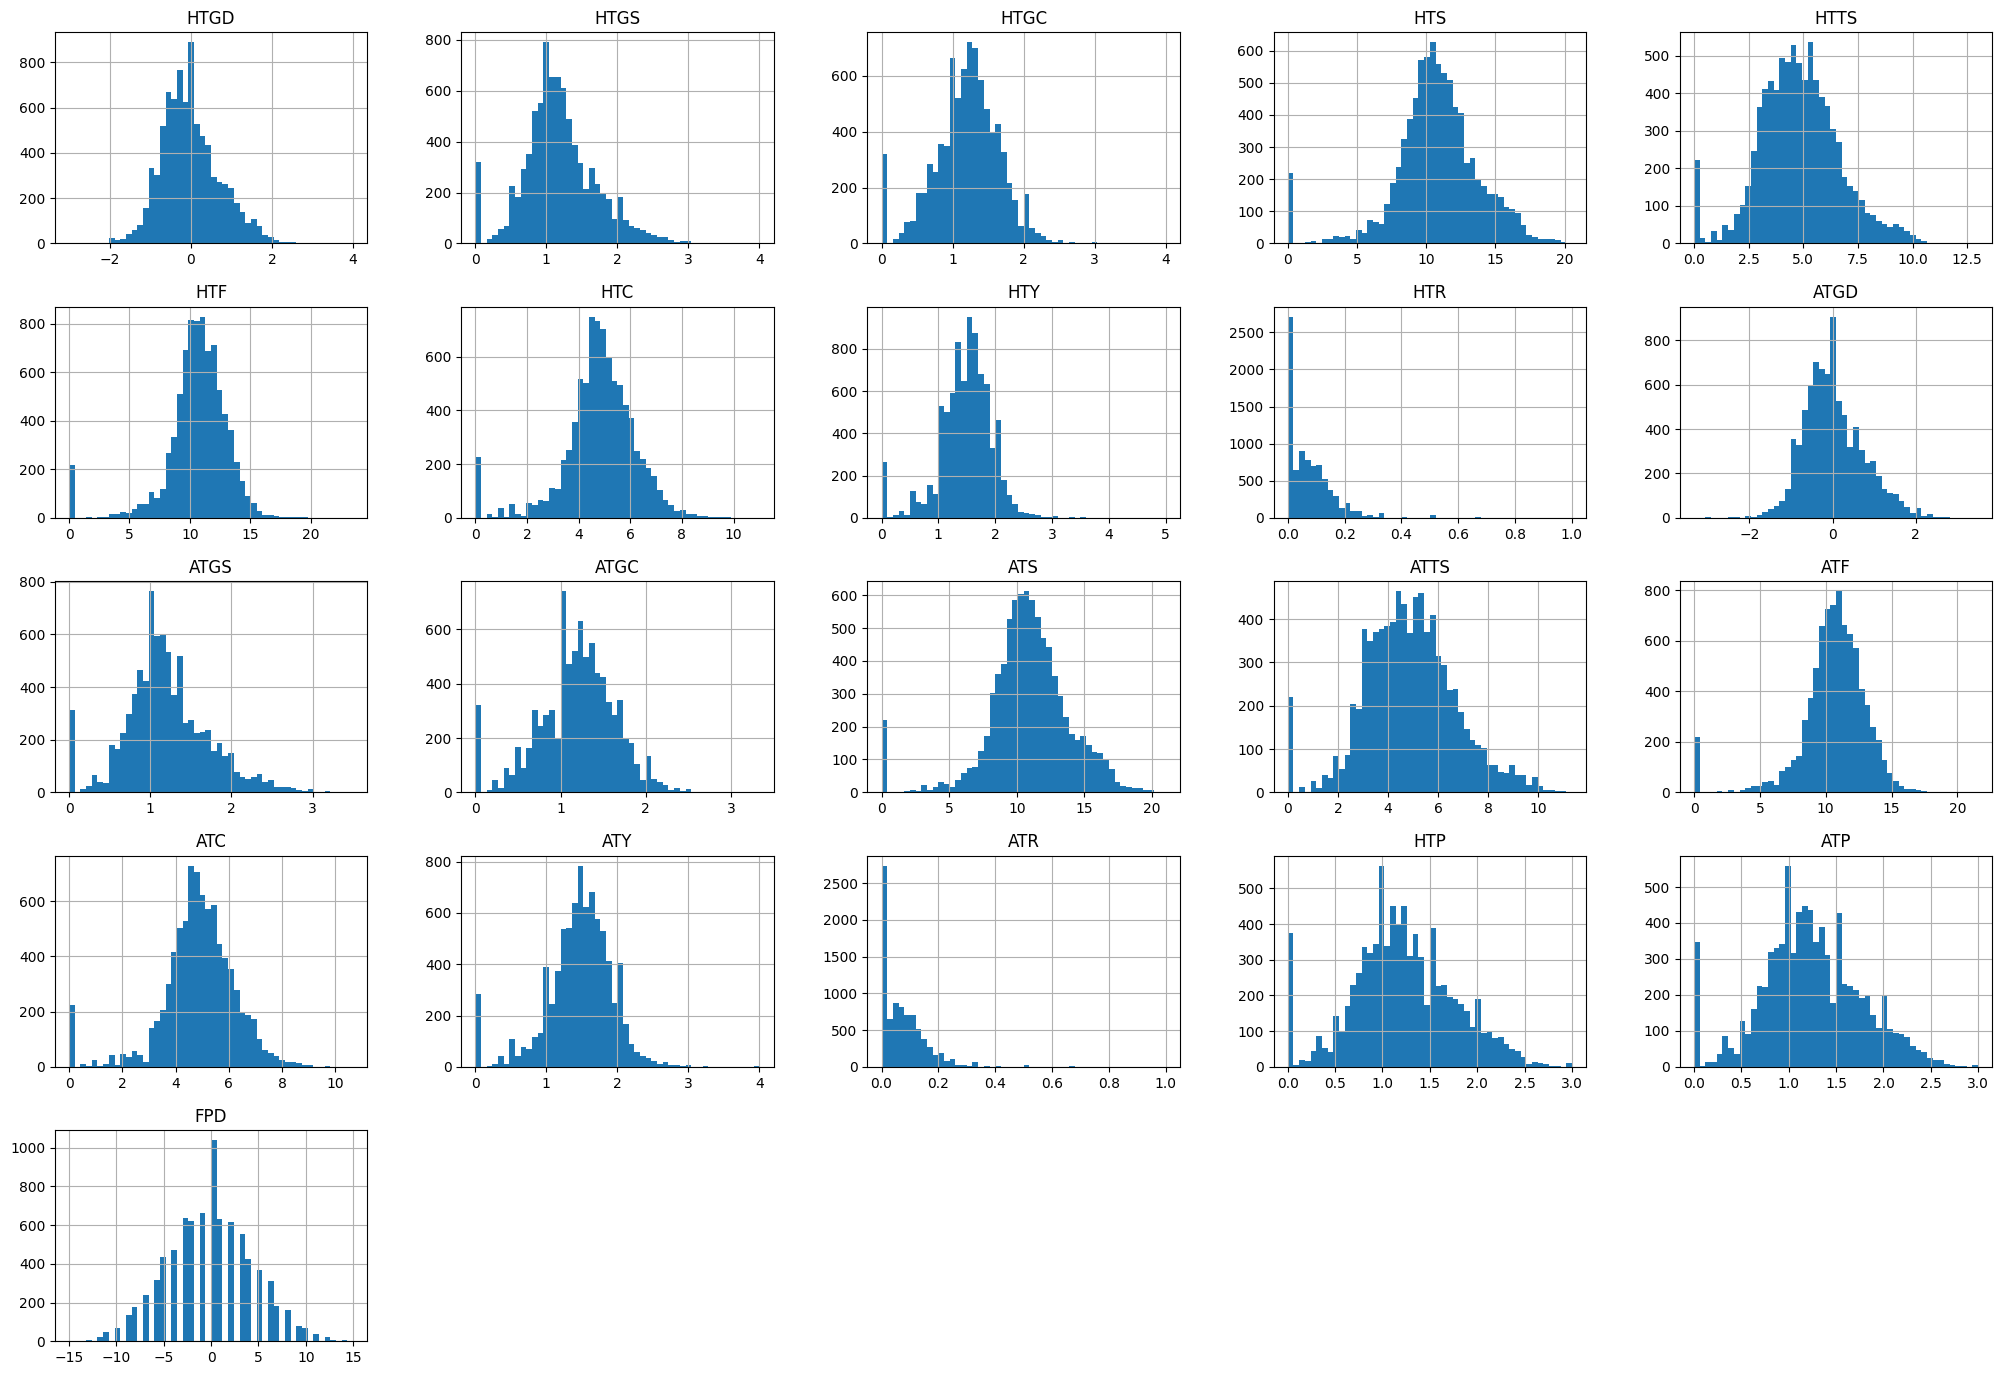

In [399]:
stats_df[cols].drop(columns=['HW','MW']).hist(figsize=(25,17), bins=50)
plt.show()

### Pivot Table

In [400]:
pivot_df = stats_df[cols].drop(columns='MW')

pd.pivot_table(pivot_df, index='HW',values=pivot_df.columns[1:])

,ATC,ATF,ATGC,ATGD,ATGS,ATP,ATR,ATS,ATTS,ATY,FPD,HTC,HTF,HTGC,HTGD,HTGS,HTP,HTR,HTS,HTTS,HTY
HW,,,,,,,,,,,,,,,,,,,,,
0,4.982,10.419,1.122,0.152,1.275,1.313,0.072,11.211,5.047,1.431,-1.159,4.604,10.596,1.254,-0.159,1.095,1.115,0.074,10.241,4.526,1.479
1,4.690,10.698,1.252,-0.149,1.103,1.132,0.074,10.404,4.621,1.475,0.844,5.022,10.523,1.128,0.159,1.287,1.326,0.074,11.300,5.132,1.451


### Scatter Plots 

In [349]:
home_stats = stats_df[['HomeTeam', 'AwayTeam','Date', 'Season','HTGD','FTHG','HTGS','HTGC','HS','HTS','HST', 'HTTS','HF','HC','HY','HR', 'ATGD','FTAG','ATGS','ATGC','AS','ATS','AST', 'ATTS','AF','AC','AY','AR']]
away_stats = stats_df[['AwayTeam', 'HomeTeam','Date', 'Season','ATGD','FTAG','ATGS','ATGC','AS','ATS','AST', 'ATTS','AF','AC','AY','AR', 'HTGD','FTHG','HTGS','HTGC','HS','HTS','HST', 'HTTS','HF','HC','HY','HR']]

home_mapper = dict(zip(['HomeTeam', 'AwayTeam','HTGD','FTHG','HTGS','HTGC','HS','HTS','HST', 'HTTS','HF','HC','HY','HR', 'ATGD','FTAG','ATGS','ATGC','AS','ATS','AST', 'ATTS','AF','AC','AY','AR'], 
     [ 'Team', 'Opponent','Avg Goal Diff', 'Goals', 'Avg Goals','Avg Goals Conceded','Shots','Avg Shots','Target Shots','Avg Target Shots','Fouls', 'Corners', 'Yellows', 'Reds', 'Opp Avg Goal Diff','Opp Goals', 'Avg Opp Goals','Avg Opp Goals Conceded', 'Opp Shots', 'Avg Opp Shots','Opp Target Shots', 'Avg Opp Target Shots', 'Opp Fouls', 'Opp Corners', 'Opp Yellows', 'Opp Reds']))


away_mapper = dict(zip(['AwayTeam', 'HomeTeam', 'ATGD','FTAG','ATGS','ATGC','AS','ATS','AST', 'ATTS','AF','AC','AY','AR', 'HTGD','FTHG','HTGS','HTGC','HS','HTS','HST', 'HTTS','HF','HC','HY','HR'], 
     [ 'Team', 'Opponent', 'Avg Goal Diff','Goals', 'Avg Goals','Avg Goals Conceded','Shots','Avg Shots','Target Shots','Avg Target Shots','Fouls', 'Corners', 'Yellows', 'Reds', 'Opp Avg Goal Diff','Opp Goals', 'Avg Opp Goals','Avg Opp Goals Conceded', 'Opp Shots', 'Avg Opp Shots','Opp Target Shots', 'Avg Opp Target Shots','Opp Fouls', 'Opp Corners', 'Opp Yellows', 'Opp Reds']))


home_stats.rename(columns=home_mapper, inplace=True)
away_stats.rename(columns=away_mapper, inplace=True)

home_stats['Place'] = 'Home'
away_stats['Place'] = 'Away'


team_stats = home_stats.append(away_stats).sort_values('Date')
team_stats['WDL'] = team_stats.apply(wdl, axis=1)

game_team_stats_season = team_stats.groupby(['Season', 'Team','WDL']).mean()[['Goals','Target Shots','Shots']].reset_index()

In [352]:
make_scatter(game_team_stats_season, x='Target Shots',y='Goals',animation_frame='Season',hover_name='Team', color='WDL',animation_group='Team',size='Shots')

In [353]:
make_scatter(df = stats_df, x='HTGD',y='ATGD', animation_frame='Season',hover_name='HomeTeam',size='HTP', color='Home Result')

In [354]:
make_scatter(df = stats_df, x='HTP',y='ATP', animation_frame='Season',hover_name='HomeTeam', color='Home Result')

In [355]:
x= 'HTGD'
y = 'ATGD'
z = 'FPD'

range_x = [stats_df[x].min(), stats_df[x].max()]
range_y = [stats_df[y].min(), stats_df[y].max()]
range_z = [stats_df[z].min(), stats_df[z].max()]

fig = px.scatter_3d(stats_df, x=x, y =y,z=z ,animation_frame='Season', hover_name='HomeTeam', color='Home Result',range_x= range_x, range_y=range_y, range_z = range_z, width=1200, height=800)

fig.update_traces(marker_line_width=1, marker_size=4)
fig.show()